# **Udacity Capstone Project: Sparify**

# Part 1: Project Overview and Problem Statement

Many online services make use of subscriptions where users pay monthly for a product that they are using. When the platform is online, it can be profitable to implement a "freemium" model where the service is free to the population (usually with ads) and the subscription allows for the removal of ads.

In such situations, being able to predict when a user will unsubscribe so that they can be targeted with promotions to try and convince them to stay can reduce loss of potential revenue over time. In this dataset, the actions for a given user have been recorded and will be used towards this end.

However, online platforms tend to generate high volumes of data that can be difficult to keep in memory. Big data solutions such as Spark can help to distribute the workload among several computers, allowing machine learning to be done on larger datasets.

Thus, we will use Spark in this project to help with our aim of creating a ML model to predict churn on a user level.

### Import Libraries

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import os
from tqdm import *

from time import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col

from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

plt.style.use("seaborn")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Define Functions

In [2]:
def print_cm(tp, tn, fp, fn, print_cm=True, return_cm=False):
    """
    Print confusion matrix given tp, tn, fp and fn.
    
    Note that array is in following order tp, fp, fn, tn. (Row, across)
    
    :Inputs:
        :tp: Int, True positives
        :tn: Int, True Negatives
        :fp: Int, False Positives
        :fn: Int, False Negatives
        :print_cm: Bool, if true then prints cm
        :return_cm: Bool, if true then returns cm
    :Returns:
        :cm: Confusion matrix as numpy array
    """
    
    cm = np.array([[tp, fp],
                   [fn, tn]])

    if print_cm:
        print(cm)
    
    if return_cm:
        return cm

In [3]:
def get_classification_score(tp, tn, fp, fn, print_stats=True, return_stats=False):
    """
    Prints classification scores given tp, tn, fp and fn.
    
    :Inputs:
        :tp: Int, True positives
        :tn: Int, True Negatives
        :fp: Int, False Positives
        :fn: Int, False Negatives
        :print_stats: Bool, if true then prints stats
        :return_stats: Bool, if true then returns stats
    :Returns:
        :accuracy: Number of correct classifications over number of classifications
        :precision: Number of true positives out of positive classifications
        :recall: Number of true positives out of those that should have been true positives
        :f1: Harmonic mean of precision and recall, good overall stat
    """
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    try: precision = tp / (tp + fp) 
    except ZeroDivisionError: precision = np.NaN

    try: recall = tp / (tp + fn)
    except ZeroDivisionError: recall = np.NaN
    
    try: f1 = 2*precision*recall / (precision+recall)
    except ZeroDivisionError: f1 = np.NaN
        
    if print_stats:
        print("_________________")
        print("Confusion Matrix:")
        print("\tAccuracy:", accuracy)
        print("\tPrecision:", precision)
        print("\tRecall:",recall)
        print("\tF1 Score:", f1)
        print("_________________")
        
    if return_stats:
        return accuracy, precision, recall, f1

### Spark Setup

In [4]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist();

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Showing a sample of the dataset
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

I personally like taking a look at the head of a RDD by using the `show` method and then copying and pasting the preformatted table that gets printed out into notepad++ or any other code editor. I personally find it more readable than showing a head like above.

In [8]:
# Showing a sample of the dataset
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 


We can already see that there are 12 columns in our data set.

In [9]:
# Get a quick description of the dataset
spark_description = df.describe().collect()

# Create Dict for Description Dataframe (Doing this for easy viewing)
description_dict = dict()
for i in spark_description:
    
    # Turn i into dictionary
    i = i.asDict()
    
    for k, v in i.items():
        try:
            description_dict[k].append(v)
        except KeyError:
            description_dict[k] = []
            description_dict[k].append(v)

# Create dataframe and reshape
df_desc = pd.DataFrame(description_dict).T.reset_index()
df_desc.columns = df_desc.iloc[0]
df_desc = df_desc[1:]

df_desc

0         summary   count                   mean                stddev  \
1          artist  228108      551.0852017937219    1217.7693079161374   
2            auth  286500                   None                  None   
3       firstName  278154                   None                  None   
4          gender  278154                   None                  None   
5   itemInSession  286500     114.41421291448516    129.76726201140994   
6        lastName  278154                   None                  None   
7          length  228108      249.1171819778458     99.23517921058361   
8           level  286500                   None                  None   
9        location  278154                   None                  None   
10         method  286500                   None                  None   
11           page  286500                   None                  None   
12   registration  278154  1.5353588340844272E12   3.291321616327586E9   
13      sessionId  286500      1041.526554973822     726.7762634630741   
14           song  228108               Infinity                   NaN   
15         status  286500     210.05459685863875     31.50507848842214   
16             ts  286500  1.5409568898104834E12  1.5075439608226302E9   
17      userAgent  278154                   None                  None   
18         userId  286500      59682.02278593872     109091.9499991047   

0                                                 min  \
1                                                 !!!   
2                                           Cancelled   
3                                            Adelaida   
4                                                   F   
5                                                   0   
6                                               Adams   
7                                             0.78322   
8                                                free   
9                                          Albany, OR   
10                                                GET   
11                                              About   
12                                      1521380675000   
13                                                  1   
14                     
ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku   
15                                                200   
16                                      1538352117000   
17  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...   
18                                                      

0                                                 max  
1                                   ÃÂlafur Arnalds  
2                                          Logged Out  
3                                              Zyonna  
4                                                   M  
5                                                1321  
6                                              Wright  
7                                          3024.66567  
8                                                paid  
9                                   Winston-Salem, NC  
10                                                PUT  
11                                            Upgrade  
12                                      1543247354000  
13                                               2474  
14   ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins  
15                                                404  
16                                      1543799476000  
17  Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...  
18                                                 99

## Data Cleaning

### First Looks

Now that the data has been imported, the first and most obvious thing to check for is missing and duplicated values. 


In [10]:
# Create Temp View
df.createOrReplaceTempView("df")

Now that this is complete, we can look at the null values for each column.

In [11]:
null_dict = {}

for i in df.columns:
    
    nulls = spark.sql("SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS null_{} \
                    FROM df \
                    where {} is null".format(i, i, i)).collect()[0]["null_{}".format(i)]
    
    print(i, nulls)
    null_dict[i] = nulls

artist 58392
auth None
firstName 8346
gender 8346
itemInSession None
lastName 8346
length 58392
level None
location 8346
method None
page None
registration 8346
sessionId None
song 58392
status None
ts None
userAgent 8346
userId None


In [12]:
# Test for unique key
spark.sql("SELECT userId, ts, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2\
        HAVING count(*) > 1 \
        ORDER BY 3 DESC \
        LIMIT 10").collect()

[Row(userId='98', ts=1538838475000, n_rows=3),
 Row(userId='95', ts=1539665400000, n_rows=3),
 Row(userId='100022', ts=1541463867000, n_rows=3),
 Row(userId='', ts=1538488477000, n_rows=2),
 Row(userId='118', ts=1540521007000, n_rows=2),
 Row(userId='152', ts=1543206099000, n_rows=2),
 Row(userId='30', ts=1543436963000, n_rows=2),
 Row(userId='36', ts=1539070836000, n_rows=2),
 Row(userId='9', ts=1539714540000, n_rows=2),
 Row(userId='132', ts=1542791668000, n_rows=2)]

In [13]:
# Find number of userid-timestamp combinations that have duplicated rows
spark.sql("WITH T AS (SELECT userId, ts, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2\
        HAVING COUNT(*) > 1 \
        ORDER BY 3 DESC \
        ) \
        SELECT COUNT(*) FROM T").collect()

[Row(count(1)=783)]

### Remove Duplicates

In [14]:
# Get an example with duplicated rows
spark.sql("SELECT * \
        FROM df \
        WHERE userId = 98\
        AND ts = 1538838475000").collect()

[Row(artist='Mase', auth='Logged In', firstName='Sawyer', gender='M', itemInSession=70, lastName='Larson', length=255.16363, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=493, song="Lookin' At Me [feat. Puff Daddy] (Album Version)", status=200, ts=1538838475000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist=None, auth='Logged In', firstName='Sawyer', gender='M', itemInSession=71, lastName='Larson', length=None, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='GET', page='Home', registration=1538069638000, sessionId=493, song=None, status=200, ts=1538838475000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist=None, auth='Logged In', firstName='Sawyer', gen

In [15]:
# Find the unique key
spark.sql("WITH T AS (SELECT userId, ts, itemInSession, page, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2, 3, 4\
        HAVING count(*) > 1 \
        ORDER BY 5 DESC \
        ) \
        SELECT COUNT(*) AS n_duplicated FROM T").collect()

[Row(n_duplicated=0)]

In [16]:
df_unique = spark.sql("WITH T AS (SELECT *, ROW_NUMBER() OVER (PARTITION BY userId, ts ORDER BY itemInSession) as rank\
                    FROM df ) \
                    SELECT * FROM T \
                    WHERE rank = 1")

# Create Temp View
df_unique.createOrReplaceTempView("df_unique")

In [17]:
# Verify clean successful
spark.sql("WITH T AS (SELECT userId, ts, itemInSession, count(*) AS n_rows \
        FROM df_unique \
        GROUP BY 1, 2, 3\
        HAVING count(*) > 1 \
        ORDER BY 4 DESC \
        ) \
        SELECT COUNT(*) AS n_duplicated FROM T").collect()

[Row(n_duplicated=0)]

Very good! We've gotten rid of events that happen on the same timestamp, which means that we've taken care of duplicated values.

In [18]:
df_unique.head(1)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=141, song=None, status=200, ts=1538391913000, userAgent=None, userId='', rank=1)]

### Missing Values


In [19]:
# Vertify All registrations have non-null in relevant columns
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS nulls 
        FROM df_unique
        WHERE registration IS NOT NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


In [20]:
# Vertify All non-registrations *have* null in relevant columns
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NOT NULL THEN 1 ELSE 0 END) AS nulls
        FROM df_unique
        WHERE registration IS NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


Alright! This is actually shaping up to be a relatively clean dataset!

Before we check the song and artist columns, we should make sure that we know which 

In [21]:
spark.sql("""
    SELECT page,
           COUNT(*)                                        AS n_rows,
           SUM(CASE WHEN song IS NULL THEN 1 ELSE 0 END)   AS null_songs,
           SUM(CASE WHEN artist IS NULL THEN 1 ELSE 0 END) AS null_artist
    FROM df_unique
    GROUP BY 1
""").collect()

[Row(page='Cancel', n_rows=52, null_songs=52, null_artist=52),
 Row(page='Submit Downgrade', n_rows=63, null_songs=63, null_artist=63),
 Row(page='Thumbs Down', n_rows=2546, null_songs=2546, null_artist=2546),
 Row(page='Home', n_rows=14235, null_songs=14235, null_artist=14235),
 Row(page='Downgrade', n_rows=2001, null_songs=2001, null_artist=2001),
 Row(page='Roll Advert', n_rows=3805, null_songs=3805, null_artist=3805),
 Row(page='Logout', n_rows=3226, null_songs=3226, null_artist=3226),
 Row(page='Save Settings', n_rows=310, null_songs=310, null_artist=310),
 Row(page='Cancellation Confirmation', n_rows=51, null_songs=51, null_artist=51),
 Row(page='About', n_rows=904, null_songs=904, null_artist=904),
 Row(page='Submit Registration', n_rows=5, null_songs=5, null_artist=5),
 Row(page='Settings', n_rows=1470, null_songs=1470, null_artist=1470),
 Row(page='Login', n_rows=3240, null_songs=3240, null_artist=3240),
 Row(page='Register', n_rows=18, null_songs=18, null_artist=18),
 Row(pag

We can see that the number of rows gives us the number of rows that should be null in the case that the page does not require that a song plays.

It seems that the only case where there are not nulls is in the case of `NextSong` where we don't expect the songs to be null.

Luckily, when this is the case, the rows are completely filled. So there does not seem to be any issues with null values that I can see.

## Exploratory Data Analysis


In [22]:
spark.sql("""
    SELECT CASE WHEN registration IS NULL THEN 0 ELSE 1 END AS is_registered,
    COUNT(DISTINCT du.userId) 
    FROM df_unique AS du 
    GROUP BY 1
    ORDER BY 1

""").collect()

[Row(is_registered=0, count(DISTINCT userId)=1),
 Row(is_registered=1, count(DISTINCT userId)=225)]

Here, we can see that there are 226 users in total. For the data that we have, almost all of them are registered (225 to be precise). We also have one user in our dataset that is not registered.

### Which pages are the most visited for each user?

In [23]:
# Find non distinct visits
response = spark.sql("""
    SELECT page, COUNT(userId) AS counts
    FROM df_unique
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

pages_non_distinct_view = [i.page for i in response]
non_distinct_view = [i.counts for i in response]

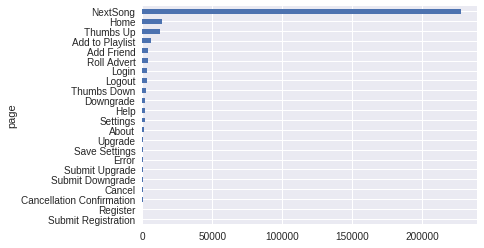

In [24]:
# Find visits for distinct users
response = spark.sql("""
    WITH user_pages AS (
        SELECT DISTINCT userId, 
                        page 
        FROM df_unique
    )
    
    SELECT page, COUNT(DISTINCT userId) AS counts
    FROM user_pages
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

distinct_view = [i.counts for i in response]

# Convert aggregated results to dataframe
df_page_vists = pd.DataFrame(dict(page = pages_non_distinct_view,
                                  distinct_view = distinct_view,
                                  non_distinct_view = non_distinct_view))

# Plot values from dataframe
ax = df_page_vists.sort_values("non_distinct_view").set_index("page")["non_distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

We can see from this graph that users tend to use the service for playing music, obviously. They will also visit the home button a lot of times and rate music that they like. 

We can see that cancellation confirmations tend to be very unlikely, which means that our dataset after the feature engineering is complete will be imbalanced.

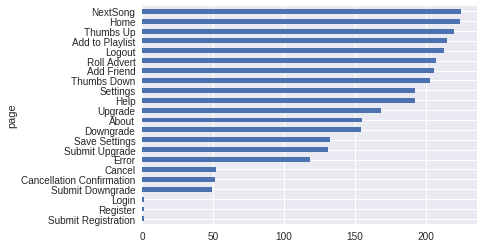

In [25]:
ax = df_page_vists.sort_values("distinct_view").set_index("page")["distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

### What location are our users mostly from?

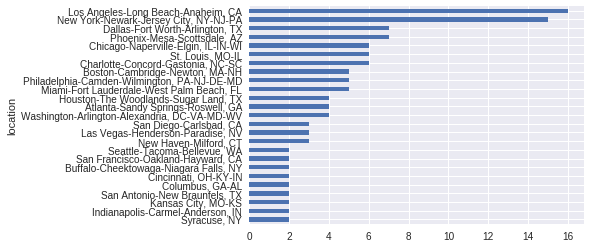

In [26]:
response = spark.sql("""
    WITH user_locations AS (
        SELECT DISTINCT userId, 
                        location 
        FROM df_unique
    )
    
    SELECT location, COUNT(DISTINCT userId) AS counts
    FROM user_locations
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 25  -- Note that without a limit, the graph will overplot
""").collect()

location = [i.location for i in response]
location_counts = [i.counts for i in response]

df_locations = pd.DataFrame(dict(location = location,
                                 location_counts = location_counts))

ax = df_locations.sort_values("location_counts").set_index("location")["location_counts"].plot(kind="barh", 
                                                                                               color=color_cycle[0])
ax.plot();

We can see that people come from various places from across the united states, Mostly the south west such as California, Texas and Arizona.

However, it seems that somehow multiple cities and areas have been combined. Making this column a little less clean than I had expected.

### What does the gender distribution of our dataset look like?

In [27]:
results_gender = spark.sql("""
    WITH user_gender AS (
        SELECT DISTINCT userId, gender
        FROM df_unique
    )

    SELECT gender, COUNT(*) AS counts
    FROM user_gender
    GROUP BY 1
    ORDER BY 1
""").collect()

results_gender

[Row(gender=None, counts=1),
 Row(gender='F', counts=104),
 Row(gender='M', counts=121)]

It seems that our gender distribution is roughly 1.16 female for every 1 male. The person with a null gender is our unregistered user.

In [28]:
# Extract gender distribution
n_males = [i.counts for i in results_gender if i.gender=='F'][0]
n_females = [i.counts for i in results_gender if i.gender=='M'][0]

n_males, n_females

(104, 121)

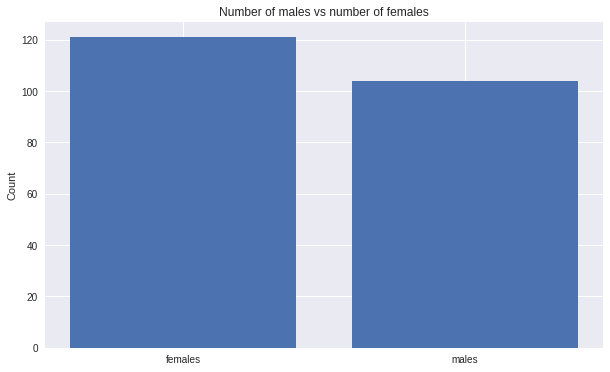

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.bar(["males", "females"], [n_males, n_females])
plt.title("Number of males vs number of females")
plt.ylabel("Count")
plt.show()